<a href="https://colab.research.google.com/github/ProxMaq/ProxVision/blob/main/Train_currency_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset link to download in colab

In [ ]:
# !gdown --id "1bSZV_fzH8FP007DZI01BZiBVjExyvHKc"

In [ ]:
%cd /content/drive/MyDrive/DataSet/indian_currency_new/

/content/drive/MyDrive/DataSet/indian_currency_new


In [ ]:
!ls

testing  training  validation  Xception_model.h5


In [ ]:
import tarfile
import os
import shutil

In [ ]:
# with tarfile.open('indian_currency_new.tar.xz') as f:
#   f.extractall('.')

In [ ]:
DIR = './content/drive/MyDrive/DataSet/indian_currency_new'

In [ ]:
# !mkdir ./testing

In [ ]:
!ls

testing  training  validation


In [ ]:
SRC = DIR + '/validation'
DST = DIR + '/testing'

In [ ]:
# !rm -r ./training/Background
# !rm -r ./validation/Background

# **Generating a Test and Validation Dataset**

In [ ]:
for folder, subfolders, filenames in os.walk(SRC):
  if folder != SRC:
    name = folder.split('/')[-1]
    src_path = os.path.join(SRC, name)
    dst_path = os.path.join(DST, name)
    print(f'Current folder :{folder}\n')
    if not os.path.exists(dst_path):
      os.makedirs(dst_path)
    for file_ in filenames[len(filenames) // 2 :]:
      shutil.move(os.path.join(src_path, file_), dst_path)

# Training

In [ ]:
import numpy as np
import tensorflow as tf
device_name = tf.test.gpu_device_name() 
if device_name != '/device:GPU:0':  
    raise SystemError('GPU device not found') 
print('Found GPU at: {}'.format(device_name)) 

Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from PIL import Image
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import random

# Visulizing data.

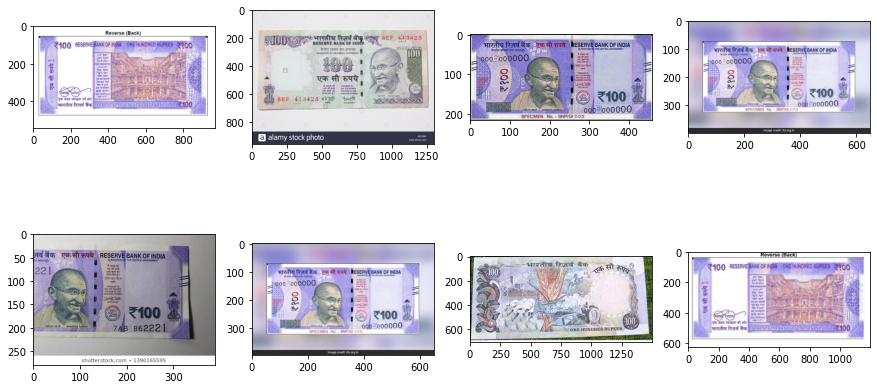

In [ ]:
img_path_100 = './training/100'
img_names = os.listdir(img_path_100)
fig, ax = plt.subplots(2, 4, figsize=(15, 7.5))
for i in range(2):
  for j in range(4):
    img_name = random.choice(img_names)
    img = plt.imread(img_path_100 + '/' + img_name)
    ax[i][j].imshow(img)

# Parameters

In [ ]:
TRAINING_DATA_PATH = './training'
IMG_SIZE = (250, 500)
NUM_CLASSES = 7
VALID_DATA_DIR = './validation'
BATCH_SIZE = 6
NUM_EPOCH = 15
FREEZE_LAYERS = 16 
LEARNING_RATE = 0.0002
DROP_OUT = .2

# **Loading a model**

In [ ]:
model = Xception(include_top = False,
              weights = 'imagenet',
              input_tensor = None,
              input_shape = (250, 500, 3))

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
'''
model = InceptionResNetV2(include_top = False,
                          weights = 'imagenet',
                          input_tensor = None,
                          input_shape = (250, 500, 3))
'''

"\nmodel = InceptionResNetV2(include_top = False,\n                          weights = 'imagenet',\n                          input_tensor = None,\n                          input_shape = (250, 500, 3))\n"

In [ ]:
top_layer = model.output
x = GlobalAveragePooling2D()(top_layer)
op = Dense(NUM_CLASSES, activation = 'softmax', name = 'softmax')(x)
model_final = Model(inputs = model.input, outputs = op)

In [ ]:
for layer in model_final.layers[:FREEZE_LAYERS]:
  layer.trainable = False

for layer in model_final.layers[FREEZE_LAYERS:]:
  layer.trainable = True

In [ ]:
model_final.compile(optimizer = Adam(lr = LEARNING_RATE),
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

In [ ]:
print(model_final.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 500, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 124, 249, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 124, 249, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 124, 249, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest',
                                   zoom_range = 0.3,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   rotation_range = 30)

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest',
                                   zoom_range = 0.3,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   rotation_range = 30)

In [ ]:
train_batches = train_datagen.flow_from_directory(TRAINING_DATA_PATH,
                                                  target_size=IMG_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode = 'categorical'
                                                  )


Found 543 images belonging to 7 classes.


In [ ]:
valid_batches = train_datagen.flow_from_directory(VALID_DATA_DIR,
                                                  target_size=IMG_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode = 'categorical'
                                                  )

Found 156 images belonging to 7 classes.


In [ ]:
class_dictionary = train_batches.class_indices
class_dictionary

{'10': 0, '100': 1, '20': 2, '200': 3, '2000': 4, '50': 5, '500': 6}

In [ ]:
checkpoint = ModelCheckpoint('Xception_model.h5', monitor = 'val_accuracy', verbose = 1,
                             save_best_only = True, save_weights_only = False,
                             mode = 'auto')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 10,
                      verbose = 1, mode = 'auto')

In [ ]:
model_final.fit_generator(train_batches,
                          steps_per_epoch = np.ceil(len(train_batches) / BATCH_SIZE),
                          validation_data = valid_batches,
                          validation_steps = np.ceil(len(valid_batches) / BATCH_SIZE),
                          epochs = NUM_EPOCH,
                          callbacks = [checkpoint, early])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
16/16 [==============================] - 79s 3s/step - loss: 1.9367 - accuracy: 0.1666 - val_loss: 1.7715 - val_accuracy: 0.3333

Epoch 00001: val_accuracy improved from -inf to 0.33333, saving model to Xception_model.h5
Epoch 2/15
16/16 [==============================] - 42s 3s/step - loss: 1.5396 - accuracy: 0.4661 - val_loss: 1.4154 - val_accuracy: 0.4667

Epoch 00002: val_accuracy improved from 0.33333 to 0.46667, saving model to Xception_model.h5
Epoch 3/15
16/16 [==============================] - 36s 2s/step - loss: 1.1422 - accuracy: 0.5701 - val_loss: 0.6784 - val_accuracy: 0.8000

Epoch 00003: val_accuracy improved from 0.46667 to 0.80000, saving model to Xception_model.h5
Epoch 4/15
16/16 [==============================] - 31s 2s/step - loss: 0.7302 - accuracy: 0.8232 - val_loss: 0.6050 - val_accuracy: 0.8333

Epoch 00004: val_accuracy improved from 0.80000 to 0.83333, saving model to Xception_model.h5
Epoch 5/15
16/16 [==============================] - 23s 1s/step

In [ ]:
test_categories = os.listdir('./testing')
test_categories

['4.jpg', '15.jpg', '45.jpg', '18.jpg', '2.jpg']

In [ ]:
class_dictionary

{'10': 0, '100': 1, '20': 2, '200': 3, '2000': 4, '50': 5, '500': 6}

In [ ]:
vals = list(class_dictionary.values())
keys = list(class_dictionary.keys())

# **Predicting on Test dataset**

In [ ]:
for p in test_categories:
  sum_confidence = 0.
  print(f'Predicting on the class {p}')
  # for img_name in os.listdir(os.path.join('./MyDrive/DataSet/indian_currency_new/testing/', p)):
  img = image.load_img('./testing' + '/' + p , target_size = IMG_SIZE)
  array = image.img_to_array(img)
  test_image = np.expand_dims(array, axis = 0)
  test_image = preprocess_input(test_image)
  prediction = model_final.predict(test_image)
  idx = np.argmax(prediction, axis = 1)
  confidence = prediction[0, idx] * 100
  digit = keys[vals.index(idx)]
  print(f'Model predict digit {digit} for image {img_name} with confidence {confidence[0]}')
  sum_confidence += confidence
  avg_confidence = sum_confidence / len(os.listdir('./testing'))
  print(f'Average confidence on class {p} is {avg_confidence}')

Predicting on the class 4.jpg
Model predict digit 200 for image g with confidence 96.66650390625
Average confidence on class 4.jpg is [19.333302]
Predicting on the class 15.jpg
Model predict digit 2000 for image g with confidence 99.91586303710938
Average confidence on class 15.jpg is [19.983173]
Predicting on the class 45.jpg
Model predict digit 100 for image g with confidence 99.98414611816406
Average confidence on class 45.jpg is [19.99683]
Predicting on the class 18.jpg
Model predict digit 20 for image g with confidence 95.89583587646484
Average confidence on class 18.jpg is [19.179167]
Predicting on the class 2.jpg
Model predict digit 20 for image g with confidence 99.94829559326172
Average confidence on class 2.jpg is [19.989658]


In [ ]:
!ls

testing  training  validation  Xception_model.h5


In [ ]:
!ls -l

total 244494
drwx------ 2 root root      4096 Apr 19 08:13 testing
drwx------ 9 root root      4096 Apr 19 08:14 training
drwx------ 9 root root      4096 Apr 19 08:14 validation
-rw------- 1 root root 250349192 Apr 19 08:28 Xception_model.h5
